<a href="https://colab.research.google.com/github/rahapirzadeh/eluvio/blob/main/internship_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# import packages needed for notebook
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import xgboost as xgb
import nltk
from sklearn.manifold import TSNE
from adjustText import adjust_text
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# read in CSV file and analyze first 5 lines
df = pd.read_csv("Eluvio_DS_Challenge.csv",skip_blank_lines=True)
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [5]:
# shape of dataset
df.shape

(509236, 8)

In [5]:
# Statistics on tne numeric columns of the dataset
print(df.describe())

       time_created       up_votes  down_votes
count  5.092360e+05  509236.000000    509236.0
mean   1.380240e+09     112.236283         0.0
std    7.090436e+07     541.694675         0.0
min    1.201232e+09       0.000000         0.0
25%    1.341585e+09       1.000000         0.0
50%    1.392909e+09       5.000000         0.0
75%    1.436527e+09      16.000000         0.0
max    1.479817e+09   21253.000000         0.0


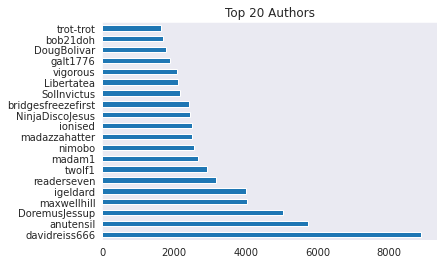

In [50]:
#Create a histogram to view the top 20 authors and the number of posts
author_bar=df['author'].value_counts()[:20].plot(kind='barh',title="Top 20 Authors")

Now I want to take a closer look at the date the post was created and look into both the year and month they were uploaded. 

In [52]:
# Split the date into month and year
df['date_created'] = pd.to_datetime(df['date_created'])
df['month_added'] = df['date_created'].dt.month_name()
df['year_added'] = df['date_created'].dt.year

In [53]:
# view the number of posts in a specific month ordered by the month with the most votes
df['month_added'].value_counts()

March        45651
July         44690
October      44069
April        43363
June         43337
September    43045
August       43042
May          41826
February     41518
November     41070
January      40258
December     37367
Name: month_added, dtype: int64

We see that the most active month is March followed by July while the least active months are December followed by January. 

In [54]:
# Create a dataframe with just the date created and the newly split month and year
net_date = df[['date_created']].dropna()
net_date['year'] = net_date.date_created.dt.year
net_date['month'] = net_date.date_created.dt.month_name()
net_date.head()


,date_created,year,month
0,2008-01-25,2008,January
1,2008-01-25,2008,January
2,2008-01-25,2008,January
3,2008-01-25,2008,January
4,2008-01-25,2008,January


Now lets view the breakdown of posts per month, per year as well and plot it. 

In [55]:
# View the newly added data in a table, displaying the month and year and the number of posts within that month and year 
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_months = net_date.groupby('year')['month'].value_counts().unstack().fillna(0)[month_order].T
df_months.head()

year,2008,2009,2010,2011,2012,2013,2014,2015,2016
month,,,,,,,,,
January,18.0,3275.0,1617.0,3155.0,3074.0,5190.0,8437.0,7824.0,7668.0
February,622.0,2671.0,1617.0,4153.0,2844.0,5436.0,8001.0,8258.0,7916.0
March,1922.0,2739.0,1960.0,4412.0,2828.0,6788.0,8855.0,8840.0,7307.0
April,2649.0,2534.0,2438.0,2938.0,2967.0,8369.0,6544.0,7241.0,7683.0
May,2786.0,1836.0,2174.0,2887.0,2625.0,7770.0,6860.0,7148.0,7740.0


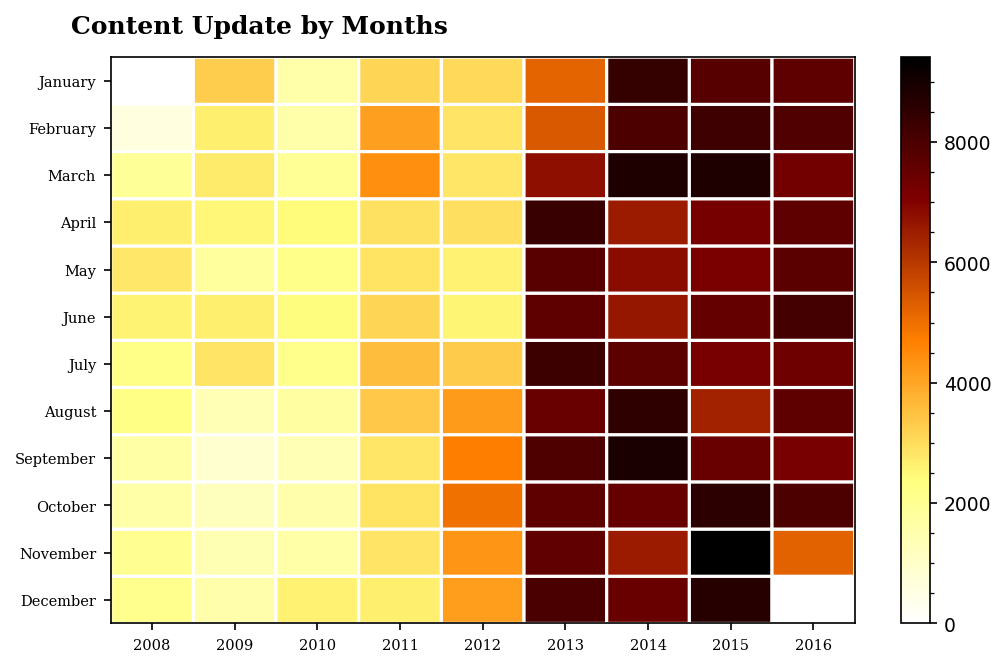

In [61]:
# plot a heat map of the number of posts in each month from 2008-2016
plt.figure(figsize=(8,5),dpi=150)
plt.pcolor(df_months, cmap='afmhot_r', edgecolors='white', linewidths=1.5)
plt.xticks(np.arange(0.5,len(df_months.columns),1), df_months.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(df_months.index), 1), df_months.index, fontsize=7, fontfamily='serif')

plt.title('Content Update by Months', fontsize=12, fontfamily='serif', fontweight='bold', position=(0.20, 1.0+0.02))
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=9)
cbar.ax.minorticks_on()

plt.show()

From the table above, we knew that March has the highest count of posts, however, with this visual, we can clearly see that overall, March does in fact have more posts, while December and January have fewer posts. One reason could also be that this dataset was collected in the middle of December and didn't fully get all the posts. But this is a great visulization to use to see if the month effects the post. 

Next, I want to look at whether the title of your post refelcts how many upvotes you recieve.

In [23]:
# get the statistical summary of up votes as well as the log of the up votes
data_sub = df[['title', 'up_votes']]

#Return the natural logarithm of one plus the input array, element-wise
data_sub['log_ups'] = np.log1p(data_sub['up_votes']) 
data_sub.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,up_votes,log_ups
count,509236.000000,509236.000000
mean,112.236283,2.071208
std,541.694675,1.828421
min,0.000000,0.000000
25%,1.000000,0.693147
50%,5.000000,1.791759
75%,16.000000,2.833213
max,21253.000000,9.964300


In [28]:
# statistics for the titles
num_of_titles = len(data_sub['title'])
max_len_title = max([len(x) for x in data_sub['title']])
avg_len_title = int(np.mean([len(x) for x in data_sub['title']]))
max_word_count = max([len(x.split()) for x in data_sub['title']])
avg_word_count = int(np.mean([len(x.split()) for x in data_sub['title']]))

print('Number of Titles: {0}'.format(num_of_titles))
print('Max Length of Title: {0} characters'.format(max_len_title))
print('Avg Length of Title: {0} characters'.format(avg_len_title))
print('Max words in Title: {0} words'.format(max_word_count))
print('Avg words in Title: {0} words'.format(avg_word_count))

Number of Titles: 509236
Max Length of Title: 320 characters
Avg Length of Title: 89 characters
Max words in Title: 64 words
Avg words in Title: 14 words


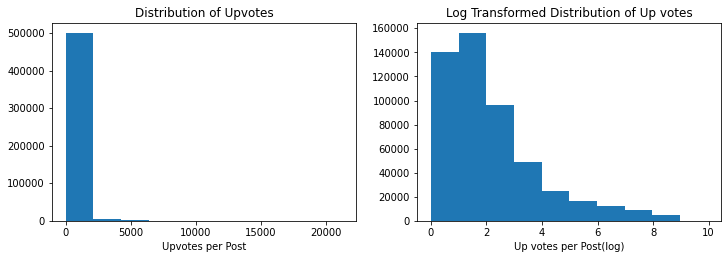

In [72]:
# Distribution of Upvotes and log transformed upvotes
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.title('Distribution of Upvotes')
plt.hist(data_sub['up_votes'])
plt.xlabel('Upvotes per Post')

plt.subplot(2,2,2)
plt.title('Log Transformed Distribution of Upvotes')
plt.hist(data_sub['log_ups'])
plt.xlabel('Upvotes per Post(log)')
plt.show()

In [76]:
# split data in to test and training sets
train_titles, test_titles, train_labels, test_labels = train_test_split(data_sub.title, data_sub.log_ups, test_size=0.20, random_state=42)

# Tokenize with specified ngram then apply tf-idf
tfidf = TfidfVectorizer(ngram_range=(1,3)).fit(train_titles, train_labels)
train_titles_tfidf = tfidf.transform(train_titles)
test_titles_tfidf = tfidf.transform(test_titles)

# Apply Linear Regression & Prediction
reg = Ridge()
reg.fit(train_titles_tfidf, train_labels)
test_predictions = reg.predict(test_titles_tfidf)

MAE: 1.4014581057595414
Mean Train: 2.0716865513678124
Mean Test: 2.0692921091748073


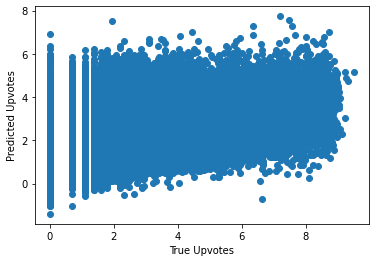

In [82]:
# print the mean of the absolute error, train and test set 
print('MAE:', mean_absolute_error(test_predictions, test_labels))
print('Mean Train:', np.mean(train_labels))
print('Mean Test:', np.mean(test_labels))

# print the plot of true votes vs. predicted votes 
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Upvotes')
plt.ylabel('Predicted Upvotes')
plt.show()

From the plot above we see that there is no direct correlation between the true votes and predicted votes. This is also because the data is not normally distributed. We don't gather much information from the model above but still a great insight to know.  


Now, to look at the posts with the most upvotes and analyze it focussing on natural language processing. 

In [100]:
# get the top 10 up votes and create a data frame
top_votes=df['up_votes'].sort_values(ascending=False).value_counts().head(10)

In [101]:
# get the titles of the top 10 posts with the highest up votes
titles=[title for title in df.sort_values('up_votes', ascending=False)['title'][:10]]

In [99]:
# combine the two dataframes to get a table of the top 10 posts 
pd.DataFrame(titles,top_votes)

,0
up_votes,
93555,A biotech startup has managed to 3-D print fak...
46619,Twitter has forced 30 websites that archive po...
44195,2.6 terabyte leak of Panamanian shell company ...
36112,The police officer who leaked the footage of t...
29917,Paris shooting survivor suing French media for...
25456,Hundreds of thousands of leaked emails reveal ...
20858,Brazil s Supreme Court has banned corporate co...
16958,ISIS beheads 81-year-old pioneer archaeologist...
13903,Feeding cows seaweed could slash global greenh...


Plot the mean number of posts over a rolling window of 120 days

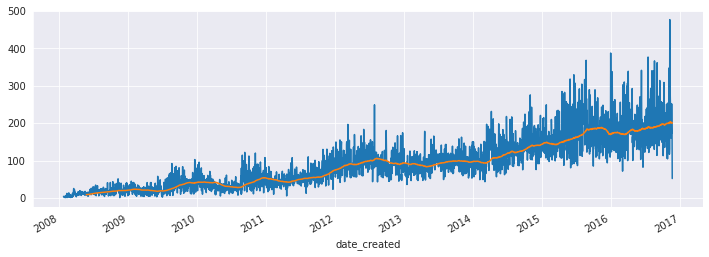

In [118]:
# plot the overall up votes to the date created to get the trend 
sns.set_style("darkgrid")
df.groupby('date_created')['up_votes'].mean().plot()
df.groupby('date_created')['up_votes'].mean().rolling(window=120).mean().plot(figsize= (12, 4))


Using word2vec, I want to analyze the titles and predict the posts success. 

In [4]:
# Grab all the titles 
article_titles = df['title']

# Create a list of strings, one for each title
titles_list = [title for title in article_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 20 words
words[:20]


['scores',
 'killed',
 'pakistan',
 'clashes',
 'japan',
 'resumes',
 'refuelling',
 'mission',
 'us',
 'presses',
 'egypt',
 'gaza',
 'border',
 'economy',
 'give',
 'health',
 'care',
 'council',
 'europe',
 'bashes']

 Load in the pre-trained word2vec model. This news dataset in particular is a Google news model which was trained on 100 billion words. 

In [5]:
# Load word2vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary = True) 

# Check dimension of word vectors
model.vector_size

300

In [6]:
# create a vector to pass through the model
economy_vec = model['economy']
economy_vec[:20] # First 20 components

array([ 0.18847656, -0.0703125 , -0.16113281,  0.03857422, -0.04956055,
       -0.23046875, -0.15722656, -0.16992188,  0.17089844, -0.01208496,
       -0.16015625, -0.02770996,  0.05932617,  0.00491333, -0.13769531,
        0.39257812,  0.06201172,  0.30859375,  0.12890625, -0.07373047],
      dtype=float32)

In [7]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
scores,0.083984,0.132812,0.177734,0.073730,0.225586,-0.140625,-0.107910,-0.083496,0.090820,-0.094238,-0.104004,-0.181641,0.076172,0.287109,0.208008,-0.054199,0.077637,0.061279,-0.192383,-0.194336,0.152344,0.045166,-0.158203,0.029785,-0.017456,-0.244141,-0.251953,0.020996,-0.257812,0.094238,-0.129883,0.009033,0.098633,-0.121094,-0.119141,0.099121,-0.025635,0.398438,0.043945,0.209961,...,-0.104980,0.394531,-0.075684,-0.005310,0.187500,0.022217,-0.020142,0.263672,0.330078,-0.129883,-0.068359,0.078613,-0.247070,-0.065430,-0.152344,0.165039,0.075195,-0.267578,-0.026978,-0.178711,0.034912,-0.003860,-0.140625,0.061768,-0.216797,-0.028198,0.085938,0.359375,0.082520,0.084473,0.041504,0.083008,-0.105469,-0.049805,-0.078613,0.237305,0.173828,-0.036377,-0.126953,0.159180
killed,0.126953,0.090332,0.263672,0.085449,0.014893,-0.175781,0.204102,-0.345703,0.225586,0.492188,0.476562,-0.230469,-0.236328,0.054199,0.123535,-0.087402,-0.324219,-0.005127,0.166992,-0.065430,-0.062500,-0.083008,-0.089355,0.048096,-0.000091,-0.263672,-0.081543,-0.103516,0.289062,-0.187500,0.333984,-0.052002,0.042725,-0.002472,0.156250,0.101562,0.259766,0.112305,-0.188477,0.402344,...,-0.237305,-0.222656,0.194336,0.120117,0.059326,0.065918,-0.229492,0.129883,-0.084961,0.100098,-0.083984,-0.048584,-0.337891,-0.170898,0.197266,-0.043213,-0.005096,0.402344,0.166016,-0.151367,-0.203125,0.208008,-0.104492,0.062256,0.062500,-0.161133,-0.300781,0.117188,0.227539,-0.000174,0.216797,-0.322266,-0.196289,0.316406,-0.066895,-0.011475,-0.162109,-0.112305,0.227539,-0.175781
pakistan,-0.486328,0.089844,0.113281,0.248047,-0.367188,0.235352,-0.012329,-0.194336,-0.361328,0.094727,-0.163086,-0.566406,-0.162109,-0.193359,-0.036377,0.220703,-0.226562,0.116699,0.061035,-0.131836,-0.040039,-0.173828,0.443359,-0.115234,-0.131836,0.447266,-0.188477,-0.103027,0.043945,-0.326172,-0.178711,0.103027,-0.515625,0.162109,-0.546875,0.259766,-0.492188,-0.022217,0.335938,-0.039795,...,0.006958,0.038818,0.326172,-0.113770,-0.167969,0.024536,-0.394531,-0.250000,0.128906,-0.116211,-0.265625,-0.026123,0.083496,0.027222,0.002609,-0.136719,0.042480,-0.107910,-0.071289,-0.146484,0.026733,0.016968,-0.085449,0.140625,-0.215820,-0.248047,-0.065430,0.196289,0.105469,-0.046875,-0.318359,0.298828,-0.048828,-0.086914,-0.230469,-0.074707,-0.095215,-0.042480,-0.165039,0.239258
clashes,0.371094,0.330078,0.106934,-0.145508,0.460938,0.090820,-0.107910,-0.423828,-0.312500,0.267578,-0.207031,-0.108398,-0.115723,0.457031,-0.165039,-0.029785,-0.349609,-0.110840,-0.066895,-0.404297,0.026855,-0.118164,0.203125,-0.007507,-0.439453,0.079590,-0.196289,-0.158203,0.300781,-0.326172,-0.092773,0.184570,0.114258,0.129883,-0.044434,0.306641,-0.061768,0.122559,-0.141602,0.328125,...,0.190430,0.253906,0.085938,0.335938,-0.188477,0.172852,-0.002411,0.070801,-0.036865,0.024048,-0.212891,-0.051514,-0.470703,-0.233398,0.137695,-0.257812,0.064453,0.165039,0.010681,0.283203,-0.219727,-0.065918,-0.100586,0.202148,0.255859,-0.308594,-0.078125,0.316406,-0.147461,-0.040283,0.183594,-0.277344,-0.005646,0.038574,0.239258,0.195312,-0.291016,-0.100586,0.078613,0.285156
japan,-0.322266,0.023071,0.177734,0.335938,-0.275391,-0.030151,-0.211914,-0.298828,0.376953,-0.113281,-0.065430,-0.353516,-0.208984,-0.147461,0.076172,0.083496,-0.072754,0.417969,0.026489,-0.326172,0.097656,-0.056396,0.384766,-0.196289,-0.476562,0.172852,-0.208008,0.046387,-0.040771,-0.104004,0.033936,0.109375,-0.357422,-0.162109,-0.198242,0.025146,-0.114258,0.059082,0.380859,0.053223,...,0.206055,-0.271484,0.294922,-0.215820,-0.077148,-0.121094,-0.259766,-0.130859,0.000404,-0.361328,-0.261719,-0.024170,0.026733,0.234375,0.217773,-0.163086,-0.050781,0.110352,-0.439453,0.251953,-0.234375,0.001419,0.235352,0.128906,0.232

Dimensional reduction done on the word vectors using t-SNE to see if any patterns emerge.

In [8]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

Plot of reduced array of word vectors

  Using cached https://github.com/Phlya/adjustText/archive/master.zip
  Created wheel for adjustText: filename=adjustText-0.8b2-cp37-none-any.whl size=9142 sha256=5896211552d0364972e238f018cd9d6432c97696e5bb27f904110d1a8acb496a
  Stored in directory: /tmp/pip-ephem-wheel-cache-mreef94_/wheels/7a/56/aa/ee86b18565ad149ba3a5470b55bbc5081701fd0b57141ed055
Successfully built adjustText


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


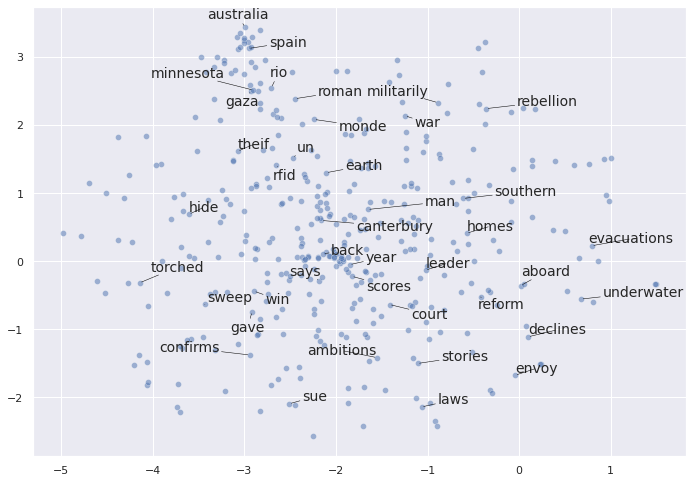

In [9]:
!pip install https://github.com/Phlya/adjustText/archive/master.zip

sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts

texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

From this, we can see similar words are plotted closely together such as countries/states and sue and laws. 

After clustering the words, I want to see if there is pattern in the titles and if they cluster together. To do this, I'm going to average th eembeddings of the word vectors in each post. 

In [15]:
def post_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# preprocessing for each post to remain a post 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will drop posts that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out posts
def filter_docs(corpus, texts, condition_on_doc):
    number_of_docs = len(corpus)
    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]
    corpus = [doc for doc in corpus if condition_on_doc(doc)]
    print("{} posts removed".format(number_of_docs - len(corpus)))
    return (corpus, texts)

In [16]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))
x = []
for doc in corpus: # append the vector for each post
    x.append(post_vector(model, doc))
    
X = np.array(x) # list to array

0 posts removed
0 posts removed


Plot the new array of post vectors with t-SNE.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


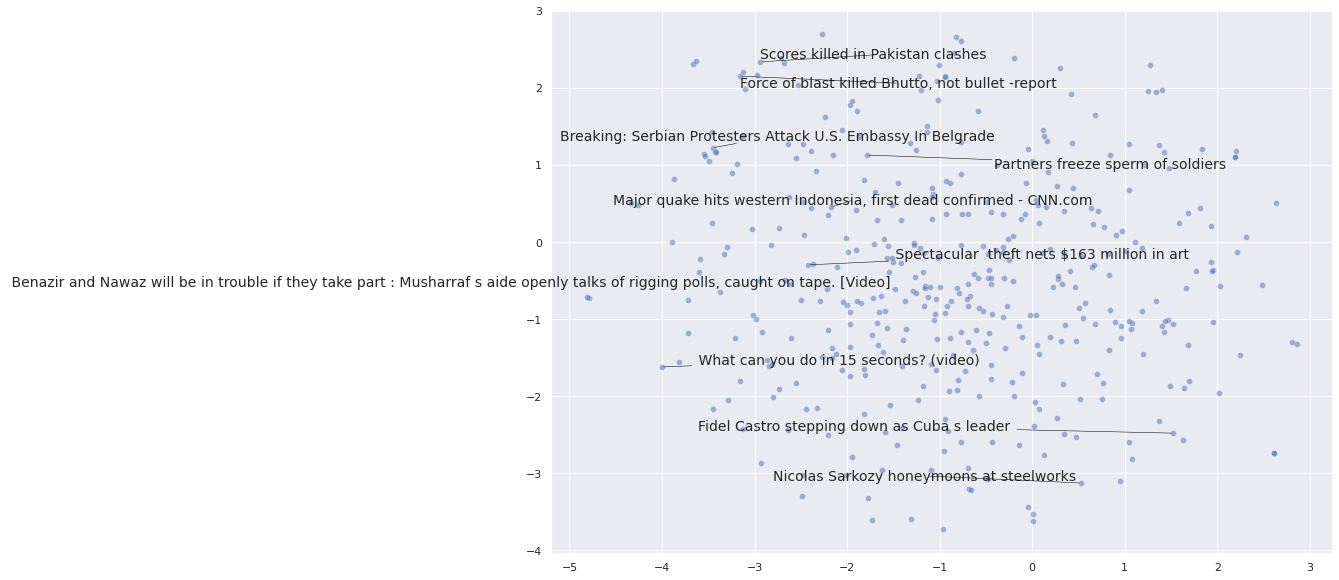

In [17]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

tsne_df = tsne.fit_transform(X[:400])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

The t_SNE collapsed the post vectors into a graph where the posts are spread on the topic of the post. For example, "Scores killed in Pakistan clashes" and Force of blast killed Bhutto, not bullet report" are closely placed on the plot. 